shape of moons: (10000, 2)


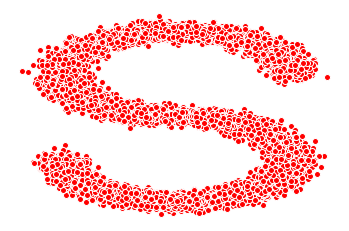

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0,2]]/10.0

print("shape of moons:", np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

# 确定超参数的值

In [29]:
num_steps = 100
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

# 计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
alpha_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alpha_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alpha_prod)
one_minus_alphas_bar_log = torch.log(1-alpha_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alpha_prod)

assert alphas.shape == alpha_prod.shape == alphas_prod_p.shape == \
alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape \
==one_minus_alphas_bar_sqrt.shape
print("all the same shape:", betas.shape)

all the same shape: torch.Size([100])


# 确定扩散过程任意时刻的采样值

In [30]:
# 计算任意时刻的x的采样值，基于x_0和参数重整化技巧
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""

    noise = torch.randn_like(x_0)   #noise是从正态分布中生成的随机噪声
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_l_m_t * noise)  # 在x[0]的基础上添加噪声

## 演示原始数据分布加噪100步后的效果

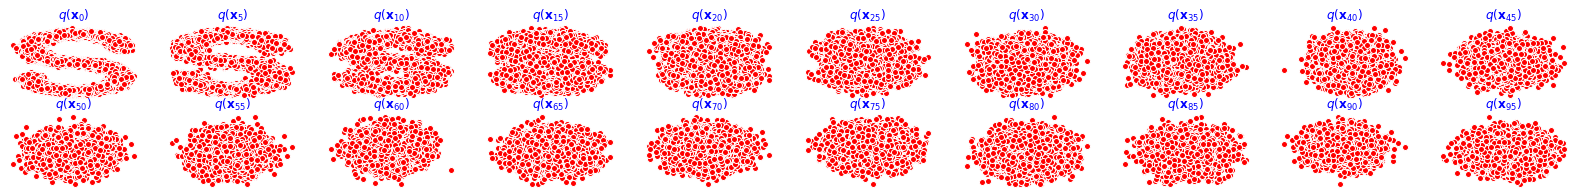

In [31]:
num_shows = 20
fig, axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='blue')

# 共有10000个点，每个点包含两个坐标
# 生成100步内每隔5步加噪后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows]))  # 生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')

    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

## 逆扩散过程

In [32]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):

    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(num_steps, num_units),
                nn.Embedding(num_steps, num_units),
                nn.Embedding(num_steps, num_units),
            ]
        )
    def forward(self, x, t):

        x = x
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)

        x = self.linears[-1](x)

        return x

In [33]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)

    # x0的系数
    a = alphas_bar_sqrt[t]

    # eps的系数
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型,得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))

    # 与真实噪声一起计算误差，求平均值
    return (e-output).square().mean()


# 编写逆扩散采样函数(inference过程)

In [34]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]..."""

    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[t]采样t时刻的重构值"""

    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x,t)

    mean = (1/(1-betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return(sample)


# 开始训练模型，并打印loss及中间的重构效果

D:\Anaconda\envs\DDPM\lib\site-packages\ipykernel_launcher.py:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


tensor(0.4568, grad_fn=<MeanBackward0>)
tensor(0.3032, grad_fn=<MeanBackward0>)
tensor(0.3820, grad_fn=<MeanBackward0>)
tensor(0.4276, grad_fn=<MeanBackward0>)
tensor(0.2776, grad_fn=<MeanBackward0>)
tensor(0.2968, grad_fn=<MeanBackward0>)
tensor(0.4409, grad_fn=<MeanBackward0>)
tensor(0.3724, grad_fn=<MeanBackward0>)
tensor(0.4294, grad_fn=<MeanBackward0>)
tensor(0.4423, grad_fn=<MeanBackward0>)
tensor(0.2200, grad_fn=<MeanBackward0>)
tensor(0.2414, grad_fn=<MeanBackward0>)
tensor(0.5181, grad_fn=<MeanBackward0>)
tensor(0.2321, grad_fn=<MeanBackward0>)
tensor(0.2700, grad_fn=<MeanBackward0>)
tensor(0.3378, grad_fn=<MeanBackward0>)
tensor(0.3567, grad_fn=<MeanBackward0>)
tensor(0.4465, grad_fn=<MeanBackward0>)
tensor(0.2530, grad_fn=<MeanBackward0>)
tensor(0.3825, grad_fn=<MeanBackward0>)
tensor(0.4016, grad_fn=<MeanBackward0>)


D:\Anaconda\envs\DDPM\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tensor(0.3913, grad_fn=<MeanBackward0>)
tensor(0.3184, grad_fn=<MeanBackward0>)
tensor(0.3661, grad_fn=<MeanBackward0>)
tensor(0.4533, grad_fn=<MeanBackward0>)
tensor(0.1490, grad_fn=<MeanBackward0>)
tensor(0.5536, grad_fn=<MeanBackward0>)
tensor(0.3340, grad_fn=<MeanBackward0>)
tensor(0.1778, grad_fn=<MeanBackward0>)
tensor(0.5171, grad_fn=<MeanBackward0>)
tensor(0.4076, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)
tensor(0.3581, grad_fn=<MeanBackward0>)
tensor(0.3674, grad_fn=<MeanBackward0>)
tensor(0.2896, grad_fn=<MeanBackward0>)
tensor(0.3063, grad_fn=<MeanBackward0>)
tensor(0.3817, grad_fn=<MeanBackward0>)
tensor(0.2321, grad_fn=<MeanBackward0>)
tensor(0.3338, grad_fn=<MeanBackward0>)
tensor(0.2637, grad_fn=<MeanBackward0>)


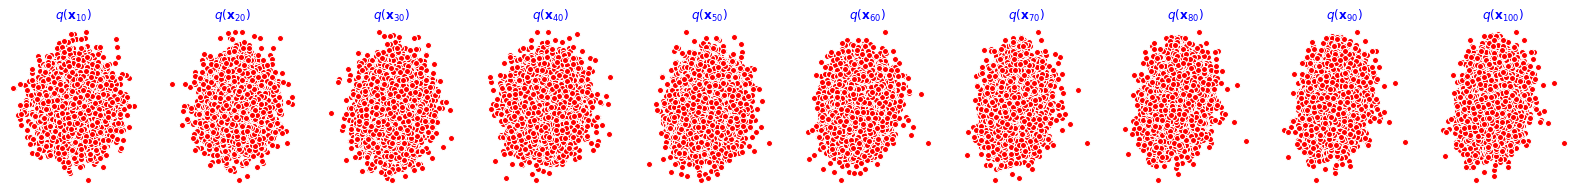

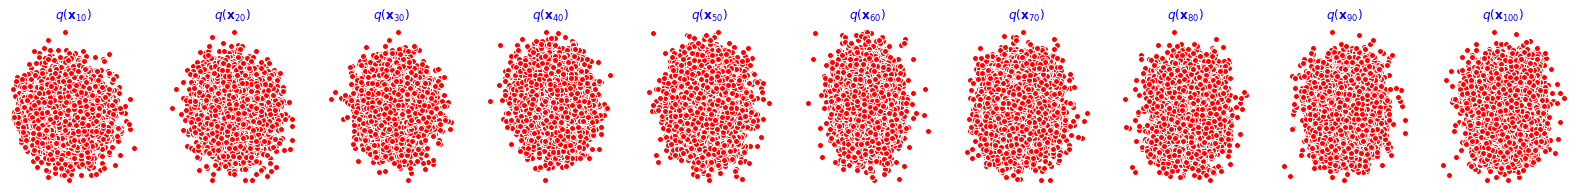

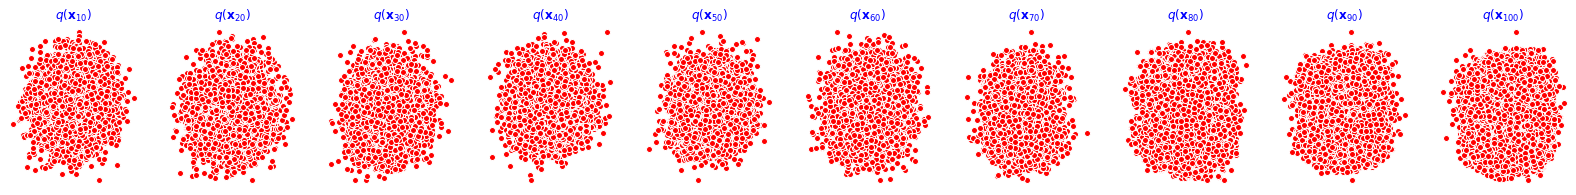

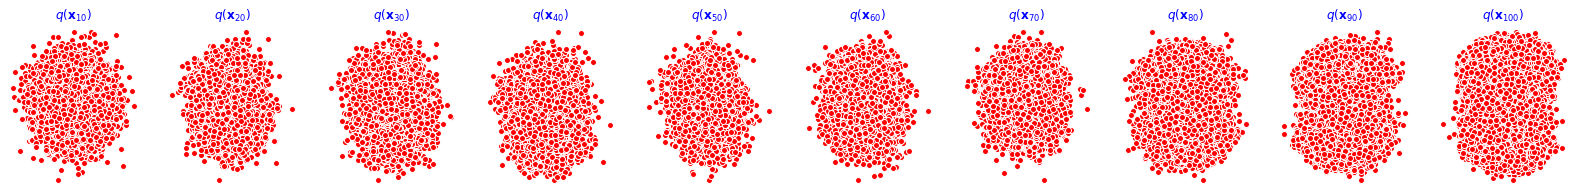

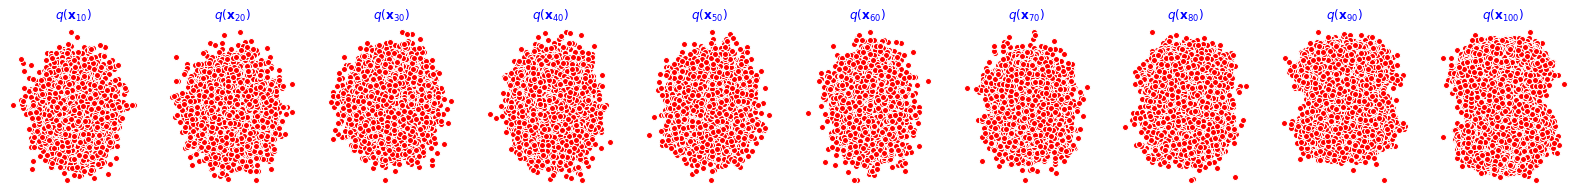

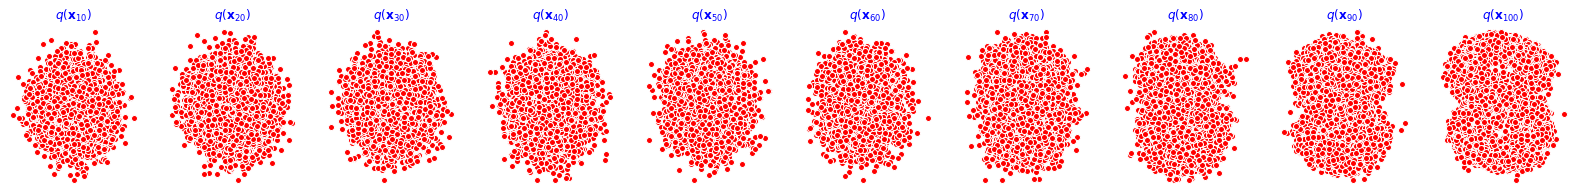

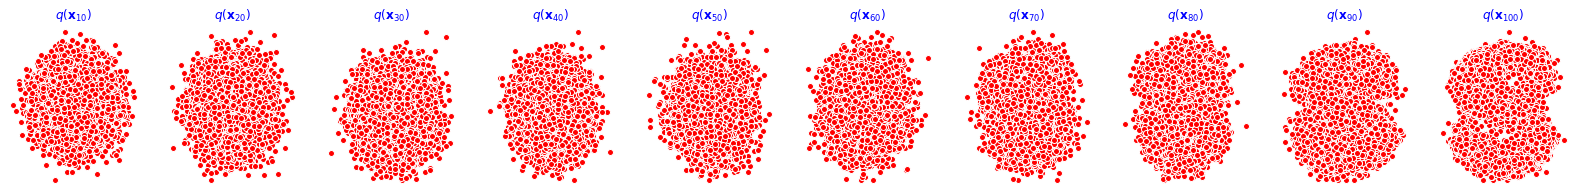

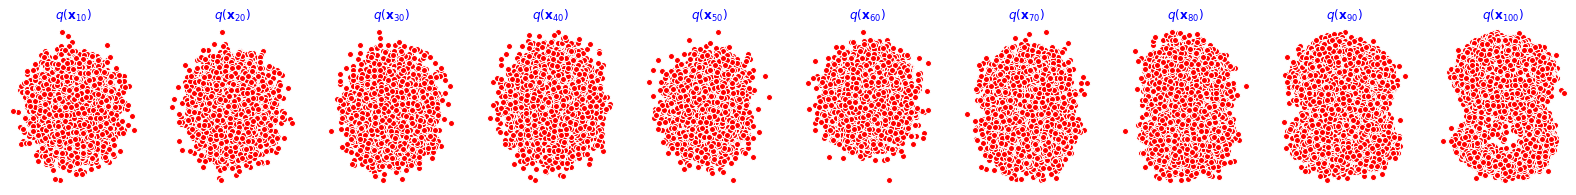

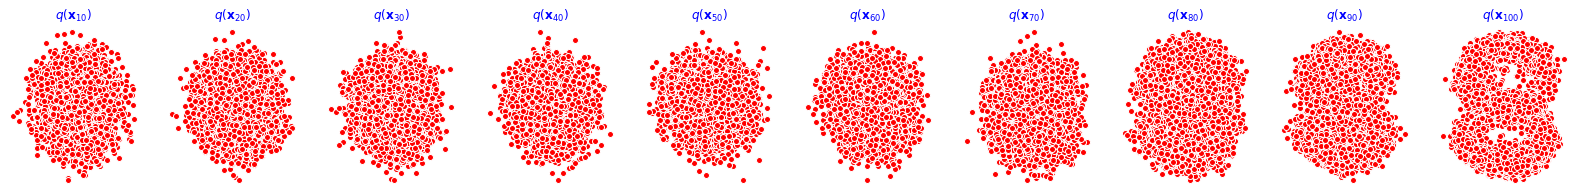

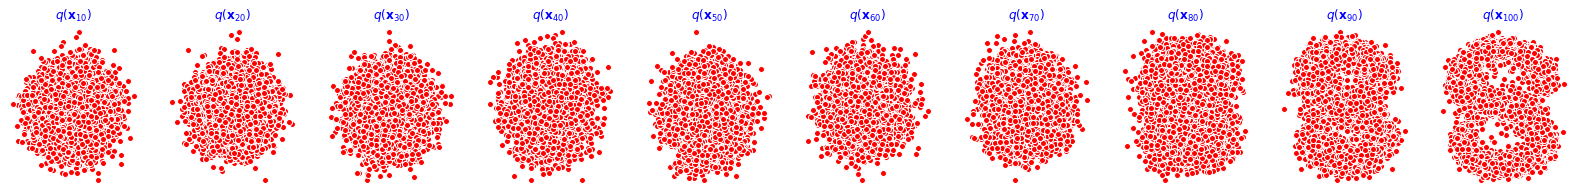

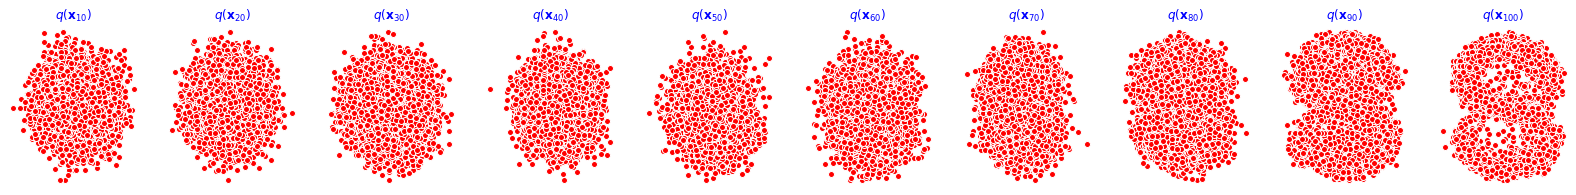

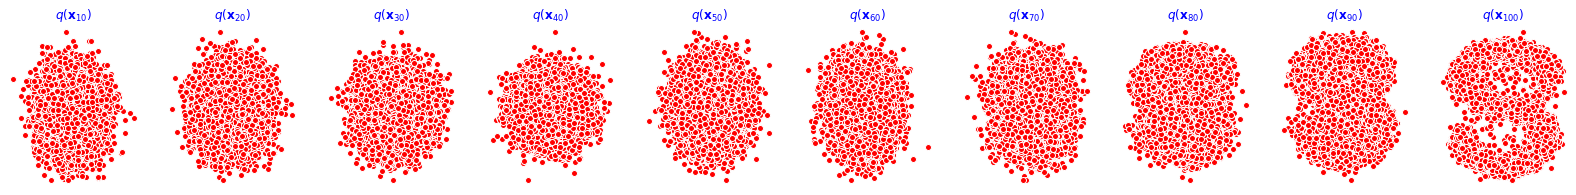

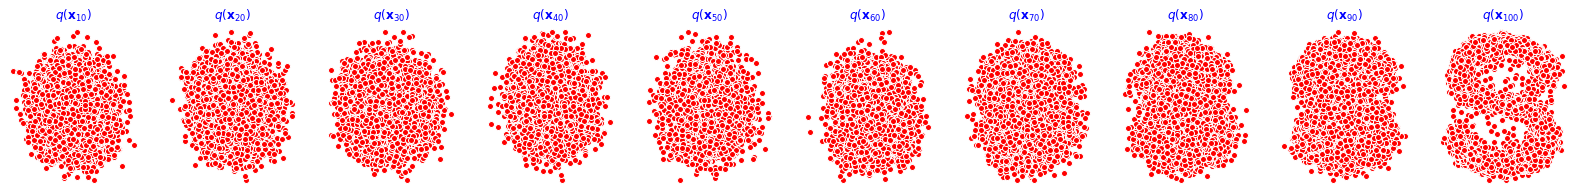

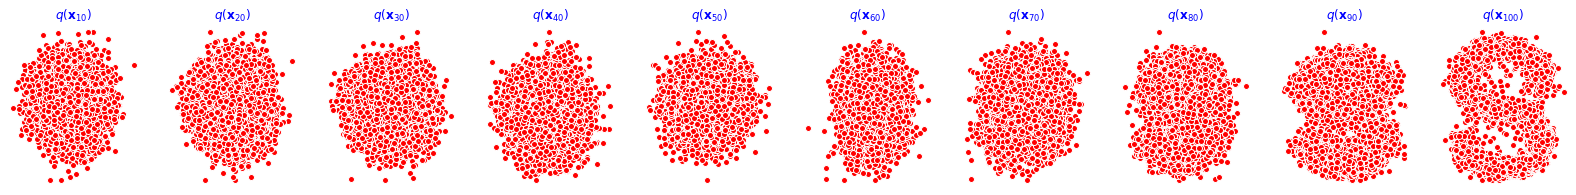

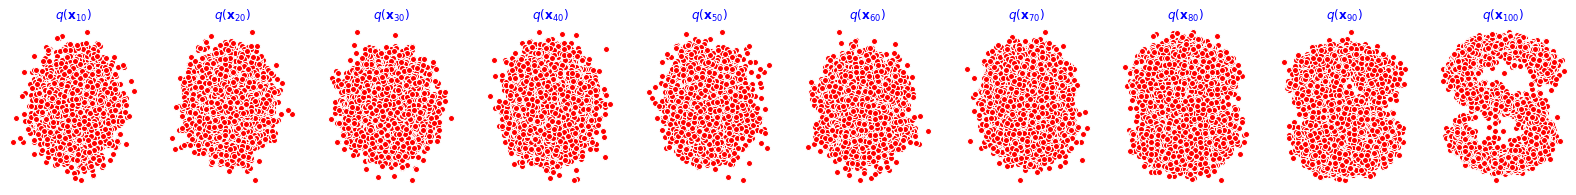

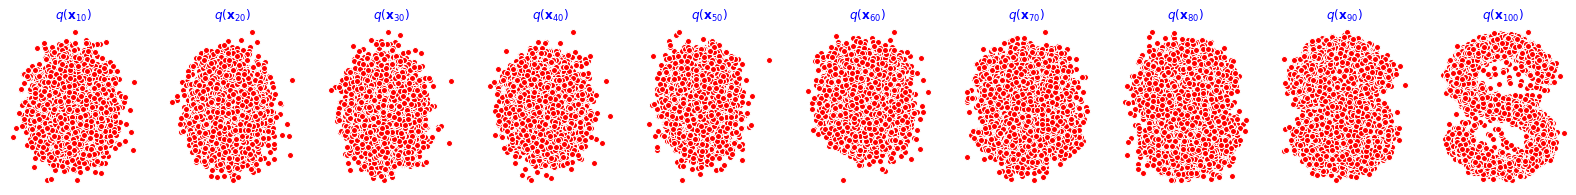

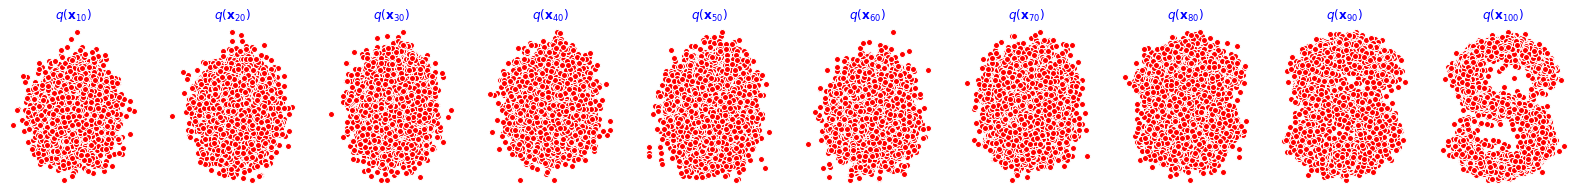

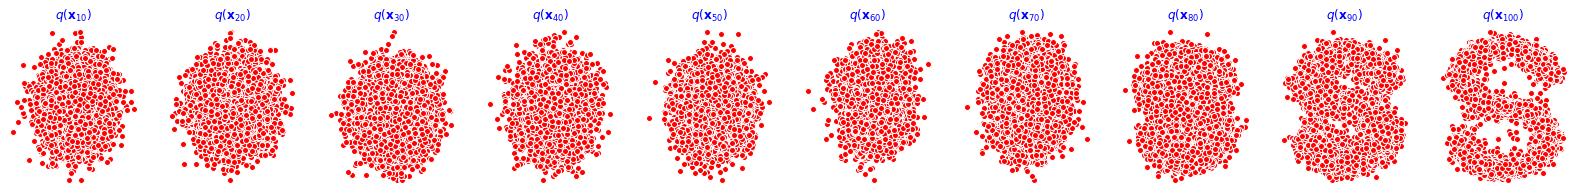

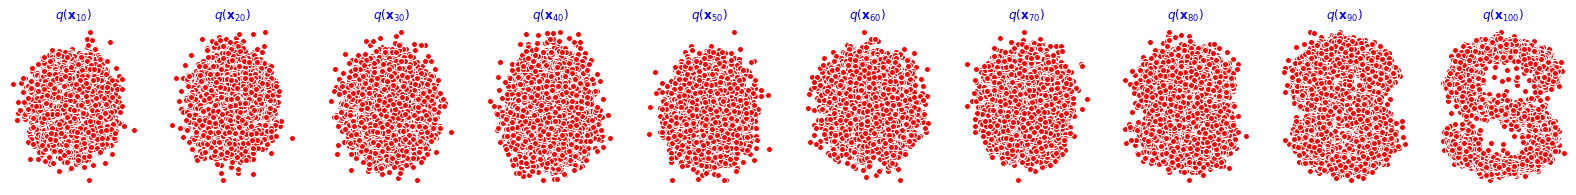

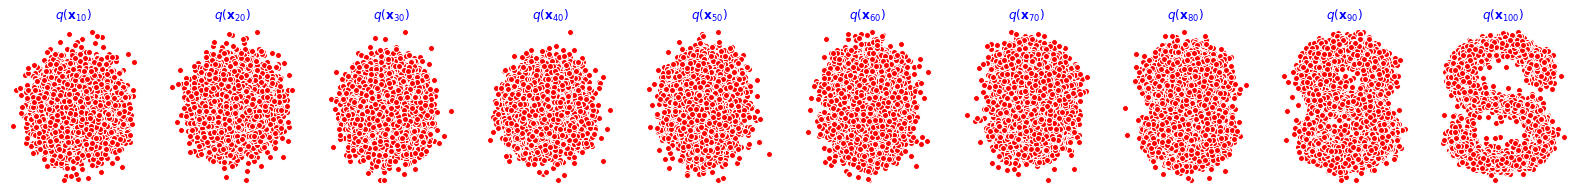

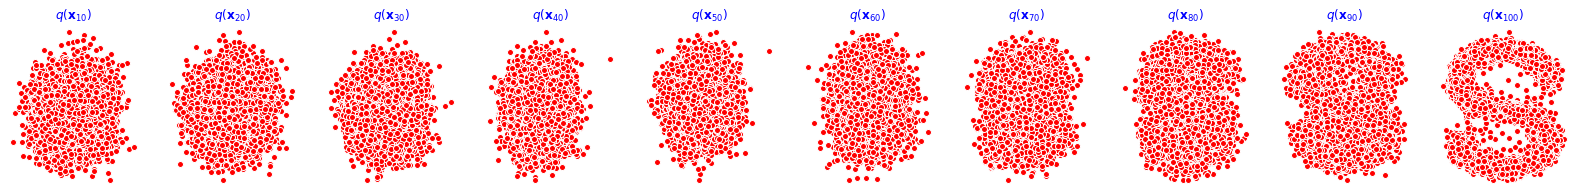

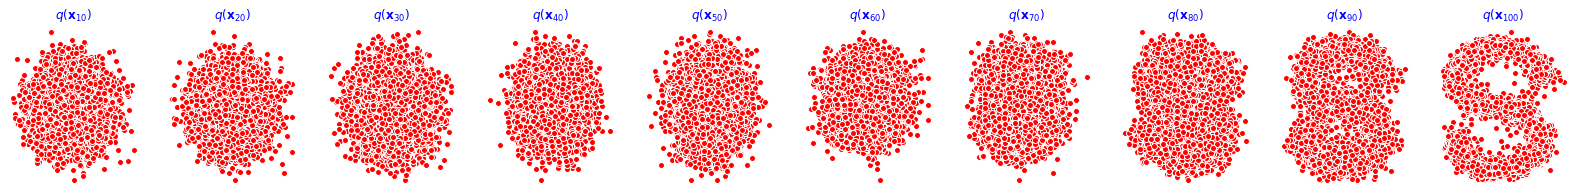

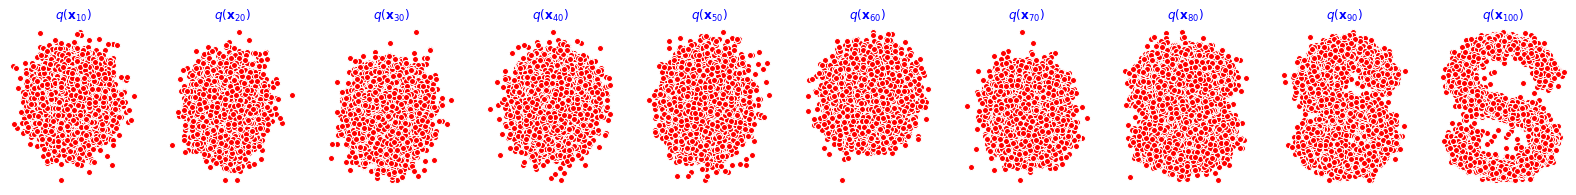

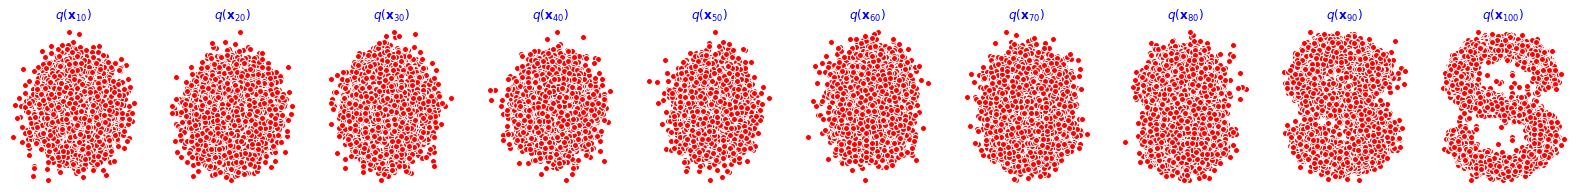

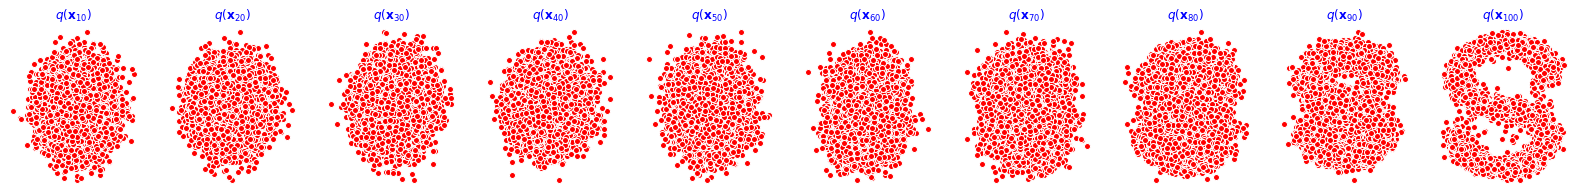

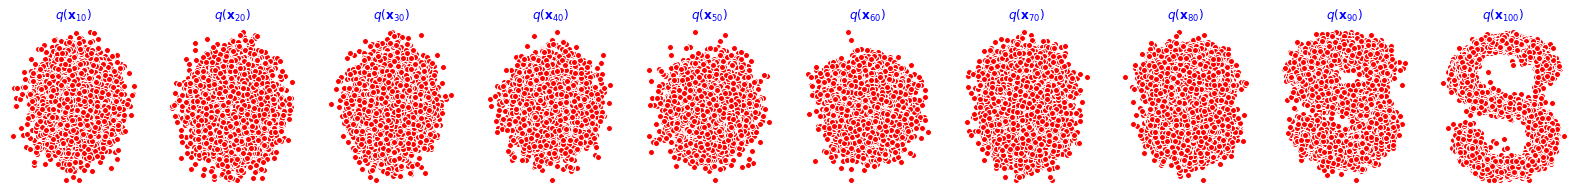

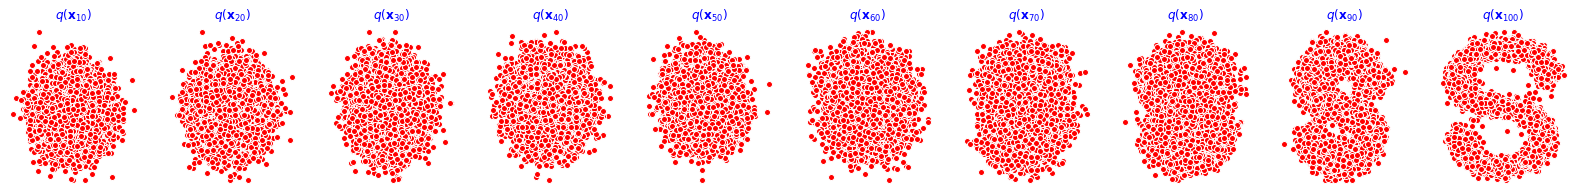

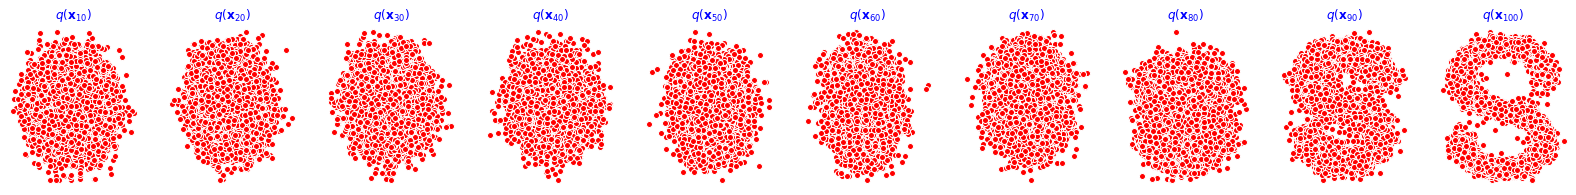

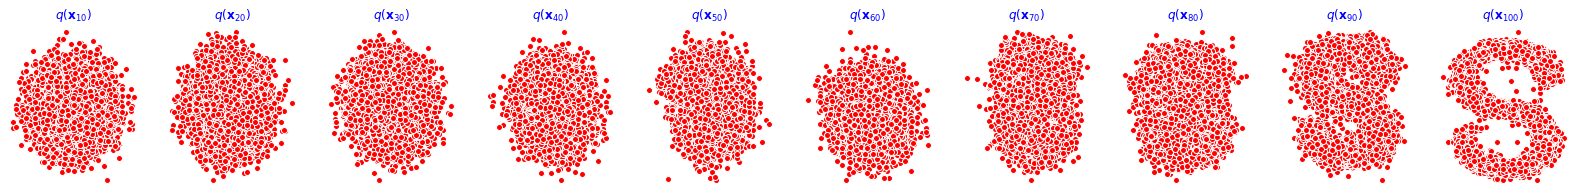

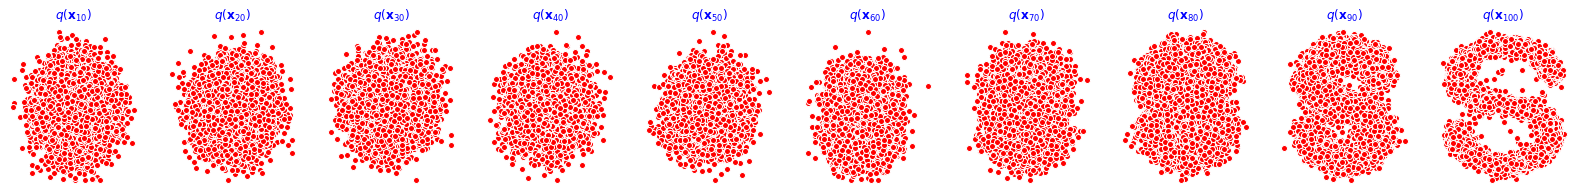

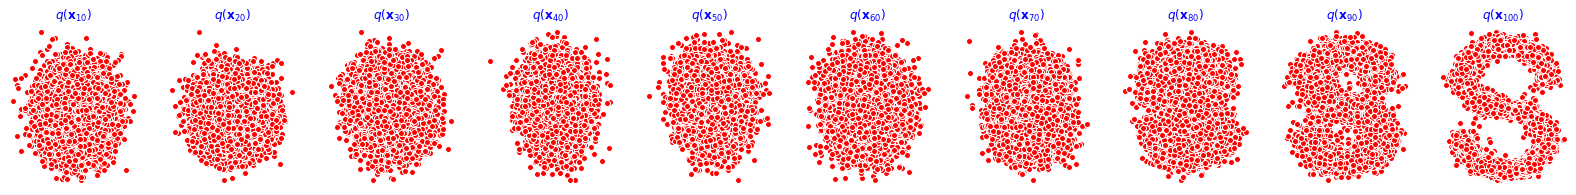

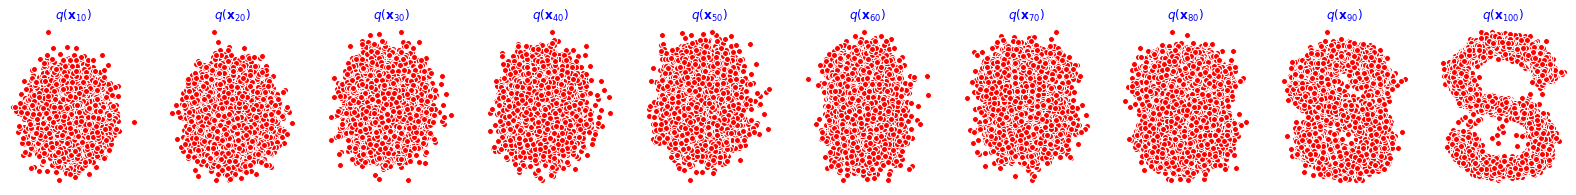

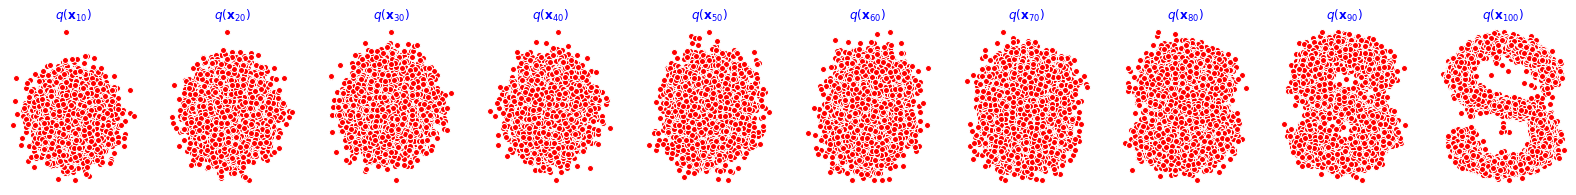

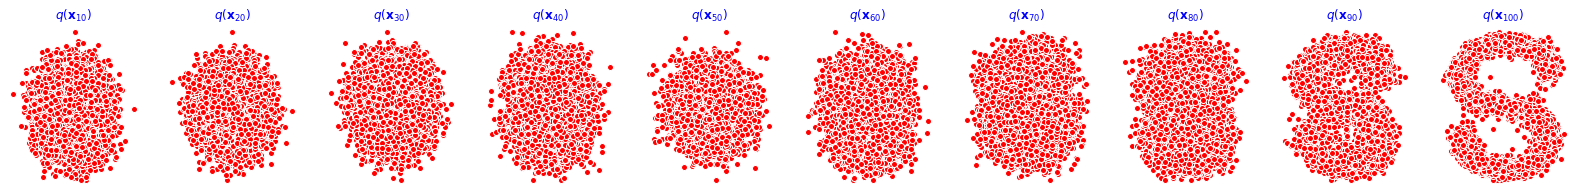

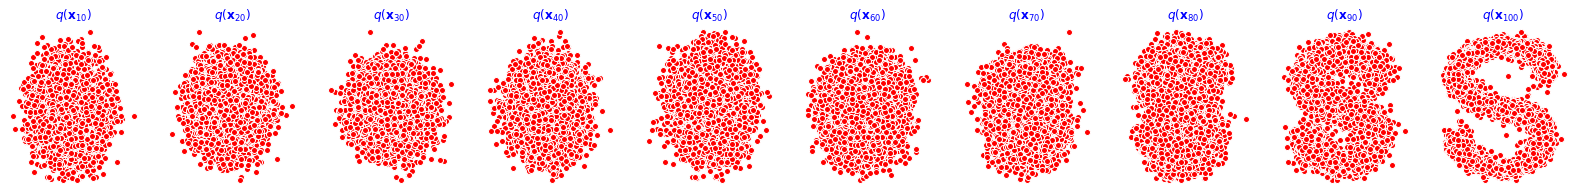

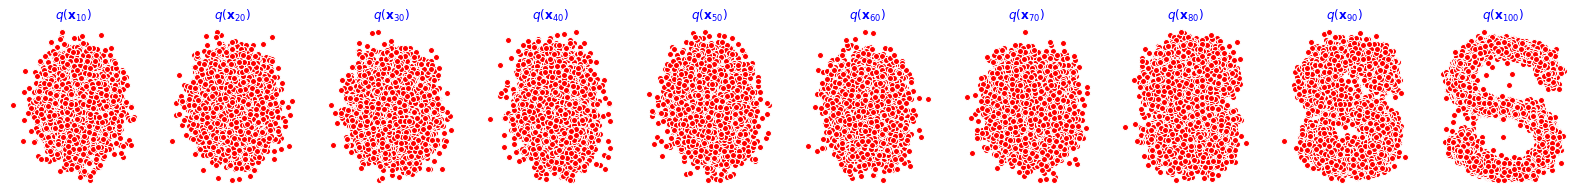

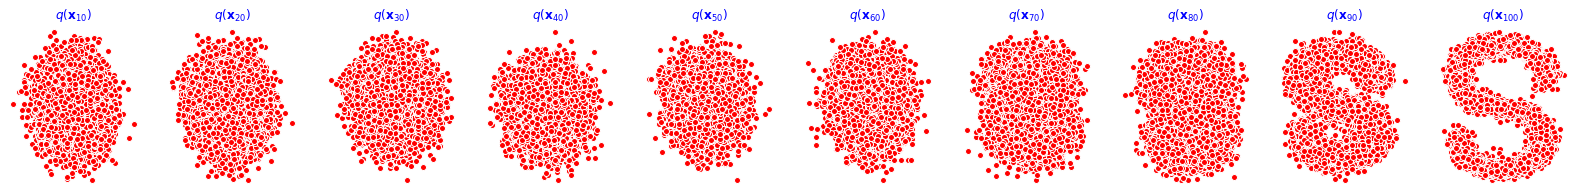

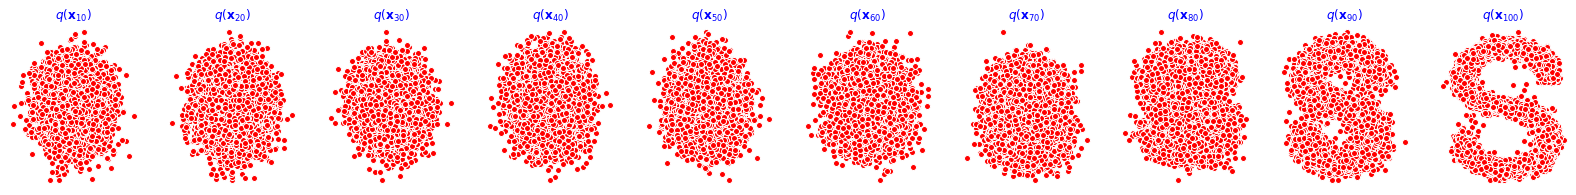

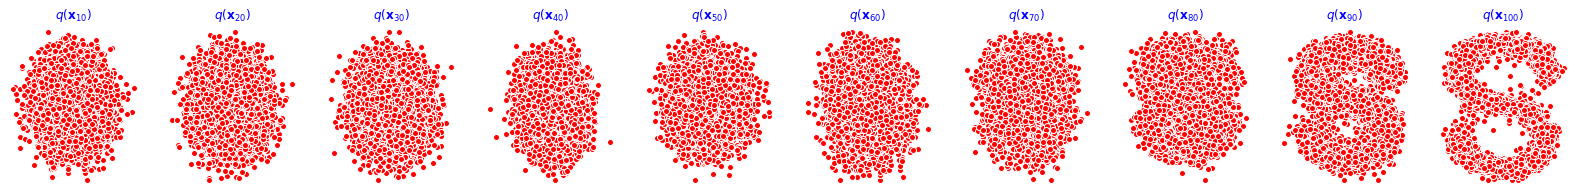

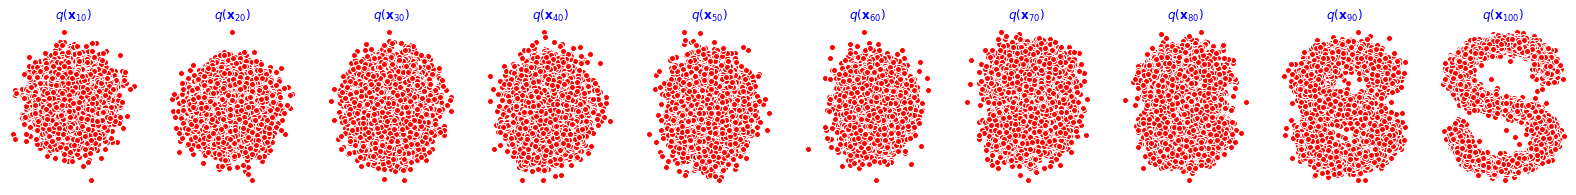

In [35]:
seed = 1234

class EMA():
    """构建一个参数平滑器"""
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(),1.)
        optimizer.step()

    # print loss
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)    # 共有100个元素

        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white')
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')


In [36]:
t = torch.randint(0, 2, size=(5,))
t = torch.cat([t, 2-1-t], dim=0)
t = t.unsqueeze(-1)
t.shape

torch.Size([10, 1])